<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/kep.png" height=75 width=75>
*This notebook uses routines from [PyKE](http://github.com/keplerGO/PyKE/) which is documented [here](http://pyke.keplerscience.org/). You can find these notebooks on [GitHub](https://github.com/christinahedges/k2torials)*

<!--NAVIGATION-->
< [What are Light Curve Files?](01.03-Investigating-LC-Files.ipynb) | [Contents](index.ipynb) | [Limb Darkening](01.05-Limb-Darkening.ipynb) >

# Folding a Light Curve

Now that we can open a light curve file and plot a light curve, we are able to see the planet transit. In the file we opened in the last notebook the transit is large and clear. We should easily be able to find a period that would be useful to fold on. Let's redraw the light curve using PyKE.

In [6]:
from pyke import lightcurve as lcf
import numpy as np
from astropy.stats import LombScargle
import matplotlib.pyplot as plt
%matplotlib inline
from pyke import targetpixelfile as tpf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


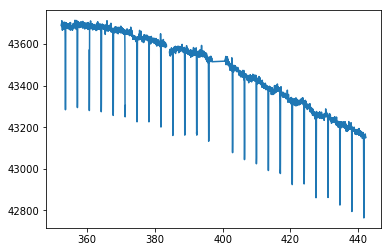

In [35]:
lc = lcf.KeplerLightCurveFile('data/kplr006922244-2010078095331_llc.fits',quality_bitmask=11111)
plt.plot(lc.time,lc.get_lightcurve('SAP_FLUX').flux)


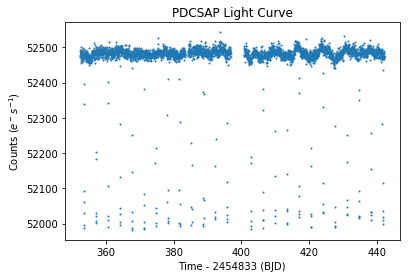

In [2]:
lc = lcf.KeplerLightCurveFile('data/kplr006922244-2010078095331_llc.fits',quality_mask='hard')
t = lc.time
flux = lc.get_lightcurve('PDCSAP_FLUX').flux
t,flux=t[np.isfinite(flux)],flux[np.isfinite(flux)]
plt.scatter(t,flux,s=1)
plt.xlabel('Time - 2454833 (BJD)')
plt.ylabel('Counts ($e^-s^{-1}$)')
plt.title('PDCSAP Light Curve')

In [5]:
from pyke import utils
type(utils.KeplerQualityFlags.DEFAULT_BITMASK)

int

Now we'll use *astropy*'s LombScargle routine to find the best period. You can read more about Lomb Scargle fitting [here](). This routine fits sinusoids and finds the best fitting periods.

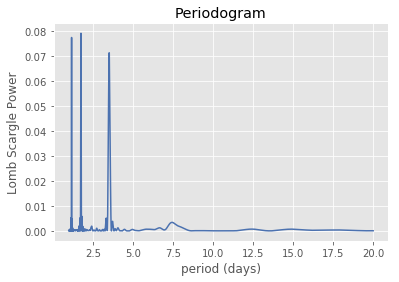

In [62]:
frequency, power = LombScargle(t, flux, flux.max()-flux.min(),nterms=1).autopower(maximum_frequency=1./1,minimum_frequency=1./20,samples_per_peak=40)
best_period = 1./frequency[np.argmax(power)]

fig, ax = plt.subplots()
ax.plot(1./frequency, power)
ax.set(xlabel='period (days)', ylabel='Lomb Scargle Power')
plt.title('Periodogram')

Above is the periodogram. The peaks show us where there is a best fit sinusoid. There are several peaks due to windowing effects. We can now fold the light curve at the best fitting period. This can be done by simply taking the modulus of the time of each observation with the period we've found. 

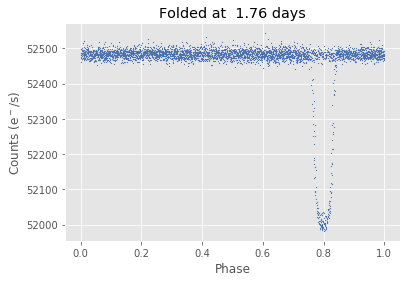

In [63]:
phase = t / best_period % 1
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')
plt.title('Folded at {:5.3} days'.format(best_period))

While this has folded to a harmonic of the correct period, this is actually half the period of the planet. Often algorithms will find a period that is half that of the true period, particularly due to deep secondary eclipses. We can rectify this by doubling the period

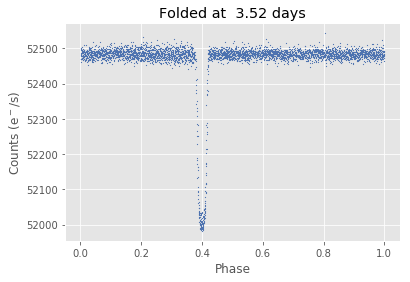

In [64]:
phase = t / (best_period*2) % 1
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')
plt.title('Folded at {:5.3} days'.format(best_period*2))

# But wait, PyKE will do this for you!

Now that you understand how period finding works you can use the inbuilt PyKE routine to find periods in your light curve file as shown below.

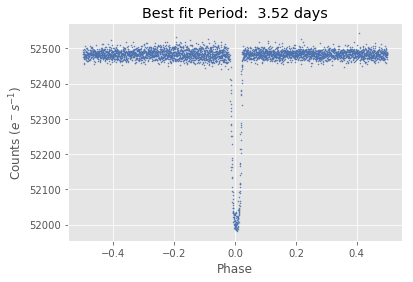

In [71]:
lc = lcf.KeplerLightCurveFile('data/kplr006922244-2010078095331_llc.fits',quality_mask='hard')
folded_time,folded_flux = lc.fold('PDCSAP_FLUX',minper=2,maxper=10,nterms=3,plot=True)

<!--NAVIGATION-->
< [What are Light Curve Files?](01.03-Investigating-LC-Files.ipynb) | [Contents](index.ipynb) | [Limb Darkening](01.05-Limb-Darkening.ipynb) >